## Chapter 5 서포트 벡터 머신

서포트 벡터 머신(support vector machine)은 매우 강력하고 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 머신러닝 모델이다. SVM은 특히 복잡한 분류 문제에 잘 들어맞으며, 작거나 중간 크기의 데이터셋에 적합하다.

### 5.1 선형 SVM 분류



In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]
y = iris['target']

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

svm_clf = SVC(kernel='linear', C=float('inf'))
svm_clf.fit(X, y)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

SVM의 기본 아이디어는 그림으로 설명하는 것이 가장 좋다. [그림 5-1]에 4장 끝에서 소개한 붓꽃 데이터셋의 일부를 나타내었다. 왼쪽 그래프 같은 경우 점선을 제외한 나머지 두 곡선은 꽤 두 집합을 잘 분류하고 있는 것처럼 보이지만, 결정 경계가 샘플에 너무 가까워 새로운 샘플에 대해서는 아마 잘 작동하지 못할 것이다. 오른쪽 그래프에 있는 실선은 SVM 분류기의 결정 경계이다. 이 직선은 두 개의 클래스를 나누고 있을 뿐만 아니라 제일 가까운 훈련 샘플로부터 가능한 한 멀리 떨어져 있다.

**즉 SVM 분류기를 클래스 사이에 가장 폭이 넓은 도로를 찾는 것으로 생각할 수 있다. 그래서 라지 마진 분류(large margin classification)이라고도 부른다.**

> SVM은 특성의 스케일에 민감하다. 특성의 스케일을 조정하면 (예를 들면 사이킷런의 `StandardScaler`를 사용하여) 결정 경계가 훨씬 좋아진다.

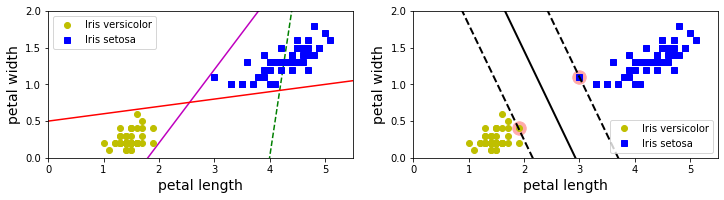

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
  W = svm_clf.coef_[0]
  b = svm_clf.intercept_[0]

  x0 = np.linspace(xmin, xmax, 200)
  decision_boundary = -W[0]/W[1] * x0 - b/W[1]

  margin = 1/W[1]
  gutter_up = decision_boundary + margin
  gutter_down = decision_boundary - margin

  svs = svm_clf.support_vectors_
  plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
  plt.plot(x0, decision_boundary, 'k-', linewidth=2)
  plt.plot(x0, gutter_up, 'k--', linewidth=2)
  plt.plot(x0, gutter_down, 'k--', linewidth=2)

plt.figure(figsize=(12, 2.7))

plt.subplot(121)
plt.plot(x0, pred_1, 'g--')
plt.plot(x0, pred_2, 'm-')
plt.plot(x0, pred_3, 'r-')
plt.plot(X[y == 0, 0], X[y == 0, 1], 'yo', label='Iris versicolor')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'bs', label='Iris setosa')
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.legend()
plt.axis([0, 5.5, 0, 2.])

plt.subplot(122)
plt.plot(X[y == 0, 0], X[y == 0, 1], 'yo', label='Iris versicolor')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'bs', label='Iris setosa')
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.legend()
plt.axis([0, 5.5, 0, 2.])

plt.show()

#### 5.1.1 소프트 마진 분류

모든 샘플이 도로 바깥쪽에 올바르게 분류되어 있다면 하드 마진 분류(hard margin classification)라고 한다. 하드 마진 분류에는 두 가지 문제점이 있다. 데이터가 선형적으로 구분될 수 있어야 제대로 작동하며, 이상치에 민감하다. 예를 들어, 아래의 왼쪽 그래프에서는 하드 마진을 찾을 수 없다. 오른쪽 그래프의 결정 경계는 이상치가 없던 위의 그래프와 결정 경계와 매우 다르고, 일반화가 잘되지 않을 것 같다.

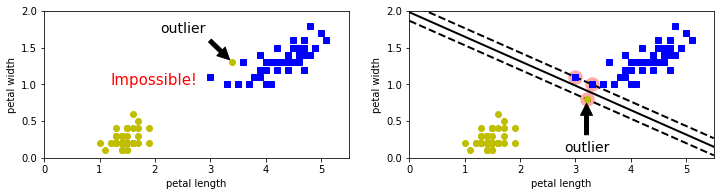

In [ ]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])

xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel='linear', C=10**9)
svm_clf2.fit(xo2, yo2)

plt.figure(figsize=(12, 2.7))
plt.subplot(121)
plt.plot(xo1[yo1 == 0, 0], xo1[yo1 == 0, 1], 'yo')
plt.plot(xo1[yo1 == 1, 0], xo1[yo1 == 1, 1], 'bs')
plt.text(1.2, 1.0, "Impossible!", fontsize=15, color="red")
plt.annotate(
    'outlier',
    xy = (X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=14,
)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.axis([0, 5.5, 0., 2.0])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.plot(xo2[yo2 == 0, 0], xo2[yo2 == 0, 1], 'yo')
plt.plot(xo2[yo2 == 1, 0], xo2[yo2 == 1, 1], 'bs')
plt.annotate(
    'outlier',
    xy = (X_outliers[1][0], X_outliers[1][1]),
    xytext = (3.2, 0.08),
    ha='center',
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=14
)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.axis([0, 5.5, 0., 2.0])
plt.show()

이런 문제를 피하려면 좀 더 유연한 모델이 필요하다. 도로의 폭을 가능한 한 넓게 유지하는 것과 마진 오류(margin violation) 사이에 적절한 균형을 잡아야 한다. 이것을 소프트 마진 분류(soft margin classification)이라고 한다.

사이킷런의 SVM 모델을 만들 때, 여러 하이퍼파라미터를 지정할 수 있다. `C`는 이런 하이퍼파라미터 중 하나이다.

여러가지 규제를 비교해보는 그래프를 만들어보도록 하겠다.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss='hinge', random_state=42)
svm_clf2 = LinearSVC(C=100, loss='hinge', random_state=42)

scaled_svm_clf1 = Pipeline([
  ('scaler', scaler),
  ('linear_svc', svm_clf1)
])

scaled_svm_clf2 = Pipeline([
  ('scaler', scaler),
  ('linear_svc', svm_clf2)
])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

`svm_clf1`과 `svm_clf2`은 학습을 할때, 데이터들의 스케일을 정규화하는 과정을 거쳤다. 하지만 우리는 이 모델들의 결정 경계를 원본 데이터와 함께 좌표평면에 표시할 계획이므로, 이 결정경계를 원본 좌표공간으로 가중치와 편향의 스케일을 복원하는 과정을 거칠 것이다.

In [ ]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

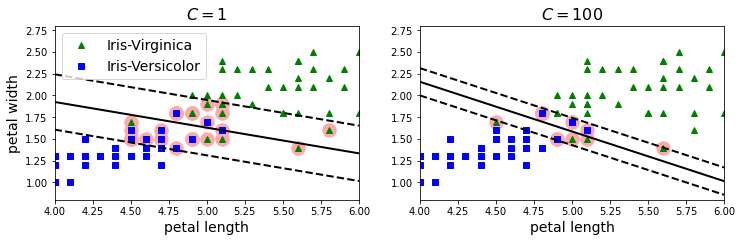

In [ ]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])
plt.show()

위 그래프를 보면, 왼쪽 그래프는 C가 낮아, 규제를 높게 설정했으므로 마진 오류가 오른쪽 그래프보다 높은 것을 알 수 있다. 반면에, 오른쪽 그래프는 C가 높아 규제를 낮게 설정했으므로, 마진 오류가 낮지만, 폭이 굉장히 좁아, 과대적합의 형상을 띄고 있다는 것을 알 수 있다.

> SVM 모델이 과대적합이라면, C를 감소시켜 모델을 규제할 수 있다.

이제 실제 코드를 사용해서 SVM 모델을 훈련시켜보자.

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]
y = (iris['target'] == 2).astype(np.int32)

svm_clf = Pipeline([
  ('scaler', StandardScaler()),
  ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X, y)
svm_clf.predict([[5.5, 1.7]])

array([1], dtype=int32)

`LinearSVC` 클래스를 대신 선형 커널을 사용하는 `SVC` 클래스로 대체할 수 있다. 예를들어 다음과 같다.

```python
svm_clf = LinearSVC(C=1, loss='hinge')
svm_clf2 = SVC(kernel='linear', C=1)

# 여기서 m은 샘플 수 이다.
# 확률적 경사 하강법은 샘플 하나씩 그레디언트를 계산하여 모델 파라미터를
# 갱신하기 때문에, 훈련 세트 수에 반비례해야 비슷한 규제를 적용할 수 있다.
svm_clf3 = SGDClassifier(loss='hinge', alpha=1/(m*C))
```

> `LinearSVC`는 `predict_proba()` 메서드를 제공하지 않지만, `SVC` 모델은 `probability=True`로 매개변수를 지정하면 `predict_proba()`메서드를 제공한다.

> `SGDClassifier`는 선형 SVM 분류기를 훈련시키기 위해 일반적인 확률적 경사 하강법을 적용한다. LinaerSVC 만큼 빠르게 수렴하지는 않지만, 데이터셋이 아주 커서 메모리에 적재할 수 없거나, 온라인 학습으로 문류 문제를 다룰 때 유용하다.

> `LinearSVC`는 규제에 편향을 포함시킨다. 그래서 훈련세트에서 평균을 빼서 중앙에 맞춰야 한다. 보통은 `StandardScaler()`를 사용한다. 또한 `loss` 매개변수를 `'hinge'`로 설정해야 한다. 마지막으로, 훈련 샘플보다 특성 수가 많지 않다면, 성능을 높이기 위해 `dual=False`으로 설정하여, 쌍대문제 대신 원문제로 접근할 수 있도록 한다.

### 5.2 비선형 SVM 분류

선형 SVM 분류기가 효율적이고 많은 경우에 아주 잘 작동하지만, 선형적으로 분류할 수 없는 데이터셋이 많다. 비선형 데이터셋을 다루는 한가지 방법은 다항 특성과 같은 특성을 더 추가하는 것이다.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)

polynomial_svm_clf = Pipeline([
  ('poly_features', PolynomialFeatures(degree=3)),
  ('scaler', StandardScaler()),
  ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

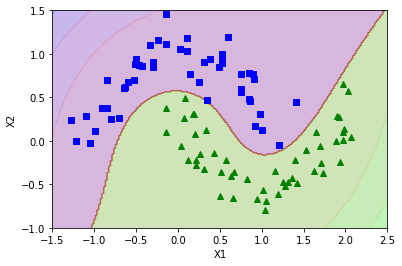

In [ ]:
def plot_predictions(clf, axes):
  X0s = np.linspace(axes[0], axes[1], 200)
  X1s = np.linspace(axes[2], axes[3], 200)
  X0, X1 = np.meshgrid(X0s, X1s)
  X_new = np.c_[X0.ravel(), X1.ravel()]
  zz = clf.predict(X_new)
  zz1 = clf.decision_function(X_new)
  plt.contourf(X0, X1, zz.reshape(X0.shape), cmap=plt.cm.brg, alpha=0.2)
  plt.contourf(X0, X1, zz1.reshape(X0.shape), cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1.0, 1.5])
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis([-1.5, 2.5, -1.0, 1.5])
plt.show()

### 5.2.1 다항식 커널

다항식 특성을 추가하는 것은 간단하고, 모든 머신러닝 알고리즘에 잘 작동한다. 하지만 낮은 차수의 다항시은 매우 복잡한 데이터셋을 잘 표현하지 못하고 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만든다.

다행히도 SVM을 사용할 땐 커널 트릭(kernel trick)이라는 거의 기적에 가까운 수학적 기교를 적용할 수 있다. 커널 트릭은 실제로는 특성을 추가하지 않으면서 많이 추가한 것과 같은 결과를 얻을 수 있다. 사실 어떤 특성도 추가하지 않기 때문에, 엄청난 수의 특성 조합이 생기지 않는다.

In [ ]:
poly_kernel_svm_clf1 = Pipeline([
  ('scaler', StandardScaler()),
  ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf2 = Pipeline([
  ('scaler', StandardScaler()),
  ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5))
])

poly_kernel_svm_clf1.fit(X, y)
poly_kernel_svm_clf2.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

위 코드는 3차 다항식 커널을 사용해 SVM 분류기를 훈련시킨다. 차수가 높을 수록 과대적합이 일어날 확률이 크다. 따라서, 과대적합이 일어나면 `degree` 파라미터의 값을 낮추어야 한다.

> 매개변수 `coef0`은 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절한다. 다항식 커널은 차수가 높아질수록 1보다 작은 값과 1보다 큰 값의 차이가 크게 벌어지므로, `coef0`을 적절한 값으로 지정하면 고차항의 영향을 줄일 수 있다.

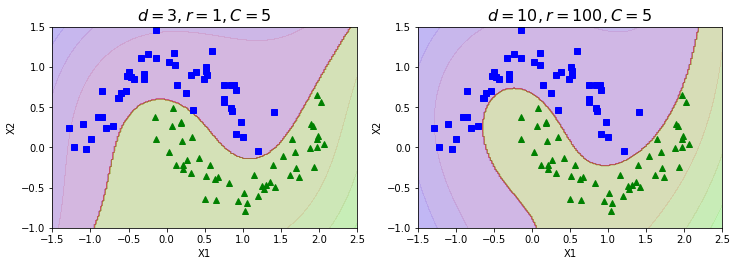

In [ ]:
plt.figure(figsize=(12, 3.7))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf1, [-1.5, 2.5, -1.0, 1.5])
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')
plt.xlabel('X1')
plt.ylabel('X2')
clf1 = poly_kernel_svm_clf1.get_params()['svm_clf']
title_params = (clf1.degree, clf1.coef0, clf1.C)
plt.title("$d = {}, r = {}, C = {}$".format(*title_params), fontsize=16)
plt.axis([-1.5, 2.5, -1.0, 1.5])

plt.subplot(122)
plot_predictions(poly_kernel_svm_clf2, [-1.5, 2.5, -1.0, 1.5])
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')
plt.xlabel('X1')
plt.ylabel('X2')
clf2 = poly_kernel_svm_clf2.get_params()['svm_clf']
title_params = (clf2.degree, clf2.coef0, clf2.C)
plt.title("$d = {}, r = {}, C = {}$".format(*title_params), fontsize=16)
plt.axis([-1.5, 2.5, -1.0, 1.5])
plt.show()

#### 5.2.2 유사도 특성

비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 랜드마크와 얼마나 닮았는지 측정하는 유사도 함수(similarity function)으로 계산한 특성을 추가하는 것이다. 가장 대표적응로 방사 기저 함수(radial basis function) 유사도 함수를 사용하여, 특성을 추가하는 기법이 있다.

> ϕ<sub>γ</sub>(X, ℓ) = exp(-γ||x-ℓ||<sup>2</sup>) <br>
* ℓ은 랜드마크 지점이다.
* γ는 0보다 커야 하며, 작을 수록 폭이 넓은 종모양이 된다.

이 함수의 값은 0부터 1까지 변화하며, 종 모양으로 나타난다. 



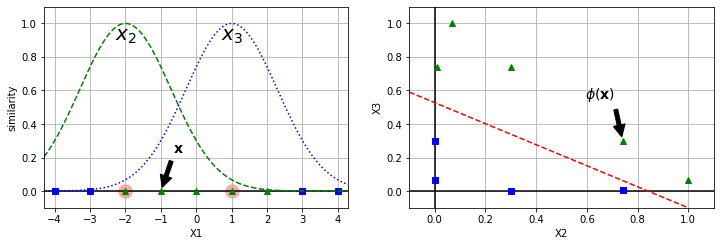

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

landmark = [-2, 1]
gamma = 0.3

x = np.linspace(-4.3, 4.3, 200)
x2 = np.exp(-gamma * (x - landmark[0]) ** 2)
x3 = np.exp(-gamma * (x - landmark[1]) ** 2)

plt.figure(figsize=(12, 3.7))

plt.subplot(121)
plt.axhline(y=0, color='k')
plt.plot([-4, -3, 3, 4], [0.] * 4, 'bs')
plt.plot([-2, -1, 0, 1, 2], [0.] * 5, 'g^')
plt.scatter([-2, 1], [0., 0.], s=180, facecolors='#FFAAAA')
plt.plot(x, x2, 'g--')
plt.plot(x, x3, 'b:')
plt.text(-2.0, 0.9, '$x_2$', fontsize=20, ha='center')
plt.text(1.0, 0.9, '$x_3$', fontsize=20, ha='center')
plt.annotate(
    r'$\mathbf{x}$',
    xy = (-1, 0.),
    xytext = (-0.5, 0.23),
    ha='center',
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=14
)
plt.xlabel('X1')
plt.ylabel('similarity')
plt.axis([-4.3, 4.3, -0.1, 1.1])
plt.grid(alpha=1.0)

plt.subplot(122)

x_b = np.array([-4, -3, 3, 4])
x_g = np.array([-2, -1, 0, 1, 2])
x2_b = np.exp(-gamma * (x_b - landmark[0]) ** 2)
x3_b = np.exp(-gamma * (x_b - landmark[1]) ** 2)
x2_g = np.exp(-gamma * (x_g - landmark[0]) ** 2)
x3_g = np.exp(-gamma * (x_g - landmark[1]) ** 2)

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(x2_b, x3_b, 'bs')
plt.plot(x2_g, x3_g, 'g^')
plt.plot([-0.1, 1.0], [0.59, -0.1], 'r--')
plt.annotate(
   r'$\phi\left(\mathbf{x}\right)$',
    xy = (x2_g[1], x3_g[1]),
    xytext = (0.65, 0.55),
    ha='center',
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=14
)
plt.xlabel('X2')
plt.ylabel('X3')
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.grid(alpha=1.0)
plt.show()

랜드마크를 설정하는 가장 간단한 방법은 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하는 것이다. 이렇게 하면 차원이 매우 커지고, 변환된 훈련세트가 선형적으로 구분될 가증성이 높다. 단점은 훈련 세트에 있는 n 개의 특성을 가진 m개의 샘플이 m개의 특성을 가진 m개의 샘플로 변환된다는 점이다. 훈련세트가 매우 클 경우, 동일한 크기의 아주 많은 특성이 만들어진다.

#### 5.2.3 가우시안 RBF 커털

유사도 함수 또한 추가 특성을 만들 때 상당한 연산 비용이 드는데, 훈련 세트가 클 경우 더 그렇다.그러나 커럴 트릭을 사용하면 실제로 특성을 추가하지도 않고, 특성을 추가한 효과를 얻을 수 있다.

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

rbf_kernel_svm_clf = Pipeline([
  ('scaler', StandardScaler()),
  ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])

rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

`gamma`를 증가시키면 종 모양 그래프가 좁아져서 각 샘플의 영향 범위가 작아진다. 이렇게 되면 결정 경계가 조금 더 불규칙해지고, 각 샘플에 따라 구불구불하게 휘어진다. 반대로, 작은 `gamma` 값은 넓은 종 모양 그래프를 만들며 샘플이 넓은 범위에 걸쳐 영향을 주므로, 결정 경계가 더 부드러워진다. 결국 하이퍼파라미터 `gamma`가 규제의 역할을 한다. 모델이 과대적합일 경우엔 감소시켜야 하고, 과소적합일 경우엔 증가시켜야 한다. 

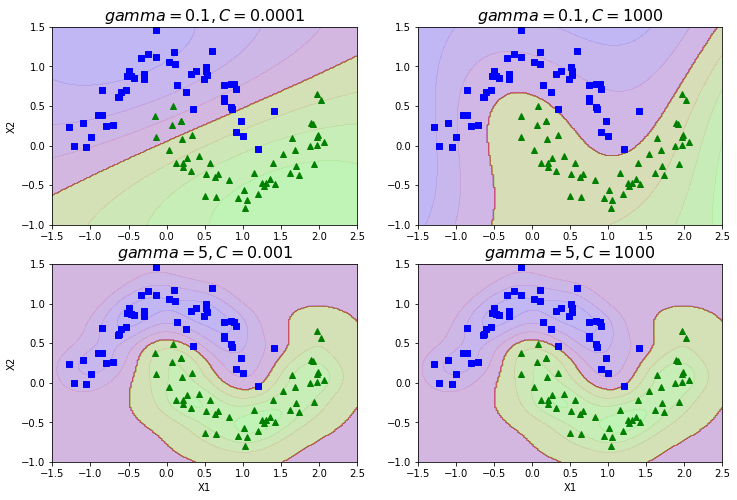

In [ ]:
rbf_kernel_svm_clf1 = Pipeline([
  ('scaler', StandardScaler()),
  ('svm_clf', SVC(kernel='rbf', gamma=0.1, C=0.001))
])
rbf_kernel_svm_clf1.fit(X, y)

rbf_kernel_svm_clf2 = Pipeline([
  ('scaler', StandardScaler()),
  ('svm_clf', SVC(kernel='rbf', gamma=0.1, C=1000))
])
rbf_kernel_svm_clf2.fit(X, y)

rbf_kernel_svm_clf3 = Pipeline([
  ('scaler', StandardScaler()),
  ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf3.fit(X, y)

rbf_kernel_svm_clf4 = Pipeline([
  ('scaler', StandardScaler()),
  ('svm_clf', SVC(kernel='rbf', gamma=5, C=1000))
])
rbf_kernel_svm_clf4.fit(X, y)

plt.figure(figsize=(12, 8))

plt.subplot(221)
plot_predictions(rbf_kernel_svm_clf1, [-1.5, 2.5, -1.0, 1.5])
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')
plt.ylabel('X2')
plt.title("$gamma = {}, C = {}$".format(0.1, 0.0001), fontsize=16)
plt.axis([-1.5, 2.5, -1.0, 1.5])

plt.subplot(222)
plot_predictions(rbf_kernel_svm_clf2, [-1.5, 2.5, -1.0, 1.5])
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')
plt.title("$gamma = {}, C = {}$".format(0.1, 1000), fontsize=16)
plt.axis([-1.5, 2.5, -1.0, 1.5])

plt.subplot(223)
plot_predictions(rbf_kernel_svm_clf3, [-1.5, 2.5, -1.0, 1.5])
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("$gamma = {}, C = {}$".format(5, 0.001), fontsize=16)
plt.axis([-1.5, 2.5, -1.0, 1.5])

plt.subplot(224)
plot_predictions(rbf_kernel_svm_clf3, [-1.5, 2.5, -1.0, 1.5])
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')
plt.xlabel('X1')
plt.title("$gamma = {}, C = {}$".format(5, 1000), fontsize=16)
plt.axis([-1.5, 2.5, -1.0, 1.5])
plt.show()

> 경험적으로 봤을 때, 여러 커널 중 선형 커널을 가장 먼저 시도해봐야 한다. (`LinearSVC`가 `SVC(kernel='linear')`보다 훨씬 빠르다는 것을 기억하자.) 특히 훈련 세트가 아주 크거나, 특성 수가 많을 경우에는 그렇다. 훈련 세트가 너무 크지 않다면, 가우시안 RBF 커널을 시도해보면 좋다.

#### 5.2.4 계산 복잡도

`LinaerSVC` 파이썬 클래스는 선형 SVM을 위한 최적화된 알고리즘을 구현한 `liblinear` 라이브러리를 기반으로 한다. 이 라이브러리는 커널 트릭을 지원하지 않지만, 훈련 샘플과 특성 수에 거의 선형적으로 늘어난다. 이 알고리즘의 훈련 시간 복잡도는 대략 O(mn) 정도이다.

SVC는 커널 트릭 알고리즘을 구현한 `libsvm`라이브러리를 기반으로 한다. 훈련 시간 복잡도는 보통 O(m<sup>2</sup>n)과 O(m<sup>3</sup>n) 사이이다. 불행하게도 이는 훈련 샘플 수가 커지면 엄청나게 느려진다는 것을 의미한다. 따라서 복잡하지만 작거나 중간 규모의 훈련세트에 적합하다.

그러나 특성 개수 같은 경우, 특히 희소 특성(sparse matrix)인 경우에는 잘 확장된다. 이런 경우 알고리즘의 성능이 샘플이 가진 0이 아닌 특성의 평균 수에 비례한다.

### 5.3 SVM 회귀

SVM은 회귀문제를 풀때도 사용될 수 있다. 이 경우, 분류문제를 풀 때와는 목표를 반대로 설정해야 한다. SVM 회귀는 제한된 마진 오류 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습한다. 도로의 폭은 하이퍼파라미터 `epsilon`으로 조절한다. 마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없다. 그래서 이 모델을 ε에 민감하지 않다 (ε-insensitive)고 말한다.

In [ ]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5)
svm_reg1.fit(X, y)

svm_reg2 = LinearSVR(epsilon=0.5)
svm_reg2.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=0.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [ ]:
def find_support_vectors(svm_reg, X, y):
  y_pred = svm_reg.predict(X)
  off_margin = np.abs(y_pred- y) >= svm_reg.epsilon
  return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

svm_reg1.coef_, svm_reg1.intercept_

(array([2.99278375]), array([3.53362371]))

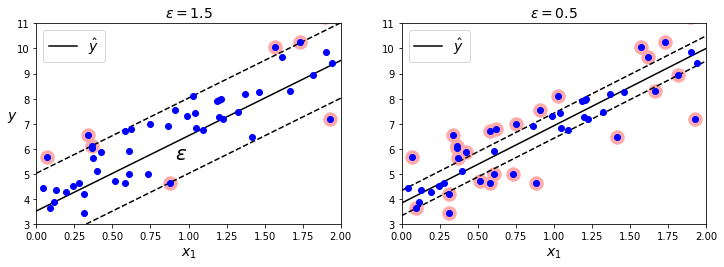

In [ ]:
def plot_support_vectors(svm_reg, X, y, axis):
  x0 = np.linspace(axis[0], axis[1], 200).reshape(-1, 1)
  y0 = svm_reg.predict(x0)

  plt.plot(x0, y0, 'k', label=r"$\hat{y}$")
  plt.plot(x0, y0-svm_reg.epsilon, 'k--')
  plt.plot(x0, y0+svm_reg.epsilon, 'k--')
  plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
  plt.legend(fontsize=14)

plt.figure(figsize=(12, 3.7))

plt.subplot(121)
plot_support_vectors(svm_reg1, X, y, [0., 2., 3, 11])
plt.plot(X, y, 'bo')
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14, rotation=0)
plt.title(r'$\epsilon = {}$'.format(svm_reg1.epsilon), fontsize=14)
plt.axis([0., 2., 3, 11])

plt.subplot(122)
plot_support_vectors(svm_reg2, X, y, [0., 2., 3, 11])
plt.plot(X, y, 'bo')
plt.xlabel(r'$x_1$', fontsize=14)
plt.axis([0., 2., 3, 11])
plt.title(r'$\epsilon = {}$'.format(svm_reg2.epsilon), fontsize=14)
plt.show()

비선형 회귀 작업을 처리하려면, 커널 SVM 모델을 사용한다. 사이킷런의 `SVR`을 사용하면 된다.

> `SVR`은 `SVC`의 회귀 버전이고, `LinearSVR`은 `LinearSVC`의 회귀 버전이다. `LinearSVR`은 필요한 시간이 훈련 세트의 크기에 비례해서 선형적으로 늘어난다.

In [ ]:
np.random.seed(42)
m = 100
X = (2 * np.random.rand(m, 1) - 1)
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [ ]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel='poly', degree=2, C=0.01, epsilon=0.1)

svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

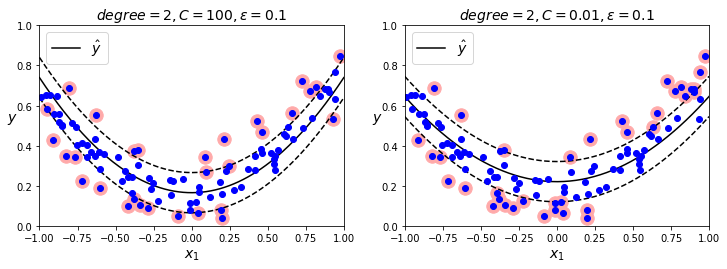

In [ ]:
plt.figure(figsize=(12, 3.7))

plt.subplot(121)
plot_support_vectors(svm_poly_reg1, X, y, [-1., 1., 0., 1.])
plt.plot(X, y, 'bo')
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14, rotation=0)
plt.title(r'$degree = {}, C = {}, \epsilon = {}$'.format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=14)
plt.axis([-1., 1., 0., 1.])

plt.subplot(122)
plot_support_vectors(svm_poly_reg2, X, y, [-1., 1., 0., 1.])
plt.plot(X, y, 'bo')
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14, rotation=0)
plt.title(r'$degree = {}, C = {}, \epsilon = {}$'.format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=14)
plt.axis([-1., 1., 0., 1.])
plt.show()